<a href="https://colab.research.google.com/github/Misha-private/Demo-repo/blob/main/DiffDA0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiffDA version on Klein-beta plane with 2 level model

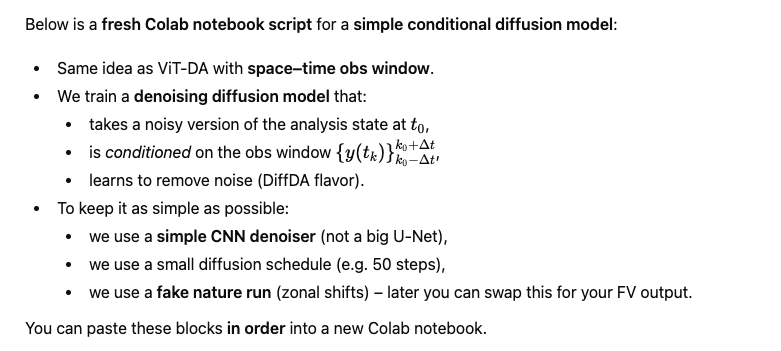

# 0. Colab setup

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# 1. Fake 2-layer SW time series on Klein-$\beta$ (nature run)

In [ ]:
# ============================================
# 1.1 Two-layer SW initial condition on Klein-β
# ============================================
def make_ic_sw2l_klein(
    Nx=64,
    Ny=32,
    Lx=2.0e7,
    Ly=6.0e6,
    g=9.81,
    H1=500.0,
    H2=500.0,
    f0=1.0e-4,
    beta=2.0e-11,
    A_bt=10.0,
    A_bc=20.0,
    alpha=1.0,
    R_frac=0.15,
    noise_amp=0.05,
    seed=None,
):
    """
    Single 2-layer SW IC on Klein-beta plane (A-grid).
    Returns h1, h2, u1, v1, u2, v2 each of shape (Ny, Nx).
    """
    rng = np.random.RandomState(seed)

    dx = Lx / Nx
    dy = Ly / Ny
    x = (np.arange(Nx) + 0.5) * dx
    y = (np.arange(Ny) + 0.5) * dy
    X, Y = np.meshgrid(x, y)

    y0 = 0.5 * Ly
    f = f0 + beta * (Y - y0)  # not used directly below

    x_c = rng.uniform(0.3 * Lx, 0.7 * Lx)
    y_c = rng.uniform(0.3 * Ly, 0.7 * Ly)
    R = R_frac * Lx

    eta_bt = A_bt * np.sin(2.0 * np.pi * X / Lx) * np.sin(np.pi * Y / Ly)
    rr2 = (X - x_c) ** 2 + (Y - y_c) ** 2
    eta_bc = A_bc * np.exp(-rr2 / R**2) * np.cos(2.0 * np.pi * X / Lx)

    eta1 = eta_bt + alpha * eta_bc
    eta2 = eta_bt - alpha * eta_bc

    h1 = H1 + eta1
    h2 = H2 + eta2
    h1 = np.maximum(h1, 1.0)
    h2 = np.maximum(h2, 1.0)

    f_ref = f0

    def ddx(field):
        return (np.roll(field, -1, axis=1) - np.roll(field, 1, axis=1)) / (2.0 * dx)

    def ddy(field):
        f_p = np.empty_like(field)
        f_m = np.empty_like(field)
        f_p[1:-1, :] = field[2:, :]
        f_m[1:-1, :] = field[:-2, :]
        f_p[0, :] = field[1, :]
        f_m[0, :] = field[0, :]
        f_p[-1, :] = field[-1, :]
        f_m[-1, :] = field[-2, :]
        return (f_p - f_m) / (2.0 * dy)

    d_eta1_dx = ddx(eta1)
    d_eta1_dy = ddy(eta1)
    d_eta2_dx = ddx(eta2)
    d_eta2_dy = ddy(eta2)

    u1 = - (g / f_ref) * d_eta1_dy
    v1 =   (g / f_ref) * d_eta1_dx
    u2 = - (g / f_ref) * d_eta2_dy
    v2 =   (g / f_ref) * d_eta2_dx

    u1 += noise_amp * rng.randn(*u1.shape)
    v1 += noise_amp * rng.randn(*v1.shape)
    u2 += noise_amp * rng.randn(*u2.shape)
    v2 += noise_amp * rng.randn(*v2.shape)

    return h1, h2, u1, v1, u2, v2


# ============================================
# 1.2 Fake nature run: zonal shifts over time
# ============================================
def build_fake_nature_run_sw2l(
    T=40,
    Nx=64,
    Ny=32,
    base_seed=123,
):
    """
    Fake time-resolved "truth" x(t) by taking one IC and
    shifting zonally over time. Later you can replace this
    with your FV model output.
    """
    C_state = 6
    truth = np.zeros((T, C_state, Ny, Nx), dtype=np.float32)

    h1, h2, u1, v1, u2, v2 = make_ic_sw2l_klein(Nx=Nx, Ny=Ny, seed=base_seed)
    state0 = np.stack([h1, h2, u1, v1, u2, v2], axis=0)  # (6,Ny,Nx)

    shift_per_t = 1  # gridpoints in x per time step

    rng = np.random.RandomState(base_seed + 1)
    for t in range(T):
        shift = shift_per_t * t
        for c in range(C_state):
            truth[t, c] = np.roll(state0[c], shift=shift, axis=1)
        # tiny noise
        truth[t] += 0.01 * rng.randn(Ny, Nx)[None, :, :]

    return truth


truth_time = build_fake_nature_run_sw2l(T=40, Nx=64, Ny=32)
print("truth_time shape:", truth_time.shape)  # (T, 6, H, W)


truth_time shape: (40, 6, 32, 64)


# 2. Anomalies and normalization

In [ ]:
# ============================================
# 2.1 Convert to anomalies
# ============================================
T, C_state, H, W = truth_time.shape

channel_means = truth_time.mean(axis=(0, 2, 3), keepdims=True)  # (1,C,1,1)
print("Channel means (original):", channel_means.reshape(-1))

truth_anom = truth_time - channel_means  # anomalies

print("Anomalies per channel (raw):")
var_names = ["h1", "h2", "u1", "v1", "u2", "v2"]
for c, name in enumerate(var_names):
    fld = truth_anom[:, c].ravel()
    print(f"{name}: min={fld.min():8.3f}, max={fld.max():8.3f}, std={fld.std():8.3f}")

# ============================================
# 2.2 Normalize anomalies to unit std per channel
# ============================================
# truth_anom has shape (T, C_state, H, W)

# Compute std over (t, y, x) for each channel, keep dims for broadcasting
channel_std = truth_anom.std(axis=(0, 2, 3), keepdims=True)  # shape (1, C_state, 1, 1)
print("Channel std (raw anomalies):", channel_std.reshape(-1))

# Avoid divide-by-zero
channel_std_safe = np.where(channel_std == 0.0, 1.0, channel_std)

# Now this broadcasts correctly: (T,C,H,W) / (1,C,1,1) ✅
truth_norm = truth_anom / channel_std_safe  # (T,C,H,W), normalized anomalies

print("Normalized anomalies per channel:")
for c, name in enumerate(var_names):
    fld = truth_norm[:, c].ravel()
    print(f"{name}: min={fld.min():8.3f}, max={fld.max():8.3f}, std={fld.std():8.3f}")



Channel means (original): [ 4.9723920e+02  5.0276083e+02 -1.6546298e-02  2.2501531e-03
  1.6284274e-02 -3.8096714e-05]
Anomalies per channel (raw):
h1: min= -19.423, max=  12.770, std=   7.551
h2: min= -13.190, max=  13.122, std=   6.148
u1: min=  -0.872, max=   0.901, std=   0.312
v1: min=  -1.016, max=   0.584, std=   0.297
u2: min=  -0.646, max=   0.588, std=   0.267
v2: min=  -0.959, max=   0.450, std=   0.264
Channel std (raw anomalies): [7.5512214  6.1480207  0.31162181 0.29687583 0.26686046 0.2642673 ]
Normalized anomalies per channel:
h1: min=  -2.572, max=   1.691, std=   1.000
h2: min=  -2.145, max=   2.134, std=   1.000
u1: min=  -2.800, max=   2.890, std=   1.000
v1: min=  -3.421, max=   1.967, std=   1.000
u2: min=  -2.422, max=   2.204, std=   1.000
v2: min=  -3.629, max=   1.702, std=   1.000


# 3. Space-time scatter observations (conditioning input)
We reuse to bilinear sampling and adjoint scatter, then build a time-window around each analysis time.


## 3.1 Bilinear sampling & scatter

In [ ]:
# ============================================
# 3.1 Bilinear sampling & adjoint scatter
# ============================================
def sample_field_bilinear(field_2d, x, y):
    """
    Bilinear sampling from a 2D field on an A-grid.
    field_2d: (H, W)
    x, y: fractional indices in [0,W), [0,H).
    Periodic in x, clamped in y.
    """
    H, W = field_2d.shape
    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    fx = x - x0
    fy = y - y0

    x1 = (x0 + 1) % W
    y1 = np.clip(y0 + 1, 0, H - 1)
    x0 = x0 % W
    y0 = np.clip(y0, 0, H - 1)

    v00 = field_2d[y0, x0]
    v10 = field_2d[y0, x1]
    v01 = field_2d[y1, x0]
    v11 = field_2d[y1, x1]

    w00 = (1.0 - fx) * (1.0 - fy)
    w10 = fx * (1.0 - fy)
    w01 = (1.0 - fx) * fy
    w11 = fx * fy

    vals = w00 * v00 + w10 * v10 + w01 * v01 + w11 * v11
    return vals


def scatter_to_grid_adj(x, y, v, H, W, eps=1e-6):
    """
    Adjoint of bilinear interpolation (points -> grid).
    Returns interpolated grid and mask indicating where obs contributed.
    """
    grid_sum = np.zeros((H, W), dtype=np.float32)
    grid_wgt = np.zeros((H, W), dtype=np.float32)

    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    fx = x - x0
    fy = y - y0

    x1 = (x0 + 1) % W
    y1 = np.clip(y0 + 1, 0, H - 1)
    x0 = x0 % W
    y0 = np.clip(y0, 0, H - 1)

    w00 = (1.0 - fx) * (1.0 - fy)
    w10 = fx * (1.0 - fy)
    w01 = (1.0 - fx) * fy
    w11 = fx * fy

    for k in range(len(v)):
        vv = v[k]
        i0, j0 = x0[k], y0[k]
        i1, j1 = x1[k], y1[k]

        grid_sum[j0, i0] += w00[k] * vv
        grid_wgt[j0, i0] += w00[k]
        grid_sum[j0, i1] += w10[k] * vv
        grid_wgt[j0, i1] += w10[k]
        grid_sum[j1, i0] += w01[k] * vv
        grid_wgt[j1, i0] += w01[k]
        grid_sum[j1, i1] += w11[k] * vv
        grid_wgt[j1, i1] += w11[k]

    grid = grid_sum / np.maximum(grid_wgt, eps)
    mask = (grid_wgt > 0.0).astype(np.float32)
    return grid, mask


## 3.2 Build space-time obs window dataset
or DiffDA we’ll keep the window pretty small: one step back, current, one step forward:

window_radius = 1 → offsets [-1, 0, +1] (3 time slices).

We treat the obs window X as conditioning for diffusion; target Y is the normalized analysis state at the center time.

In [ ]:
# ============================================
# 3.2 Make space–time scattered obs dataset
# ============================================
def make_da_dataset_spacetime_scattered_noisy_norm(
    truth_norm,
    window_radius=1,
    n_obs_points=1000,
    noise_std_obs=0.1,
    seed=123,
):
    """
    Space-time DA dataset for DiffDA, using *normalized* anomalies.

    truth_norm: (T, C, H, W)  normalized anomalies
    window_radius: number of time steps on each side of analysis time.
                   e.g. 1 -> offsets = [-1,0,1]
    n_obs_points: number of scattered obs per time slice
    noise_std_obs: Gaussian obs noise std (same units as truth_norm)
    seed: RNG seed

    For each valid analysis time k_a:
      - time offsets tau = [-R,...,+R], N_t = 2*R+1
      - for each tau:
          t_idx = k_a + tau
          sample scattered obs, add noise_std_obs, scatter-to-grid
      - Stack obs over time & channels:
          obs_stack:  (N_t * C, H, W)
          mask_stack: (N_t * C, H, W)
      - X[i] = [obs_stack, mask_stack]  shape (2*N_t*C, H, W)
      - Y[i] = truth_norm[k_a]          shape (C, H, W)

    Returns:
      X: (N_samples, C_in, H, W)
      Y: (N_samples, C,    H, W)
    """
    rng = np.random.RandomState(seed)
    T, C, H, W = truth_norm.shape

    time_offsets = np.arange(-window_radius, window_radius + 1)
    N_t = len(time_offsets)

    valid_ka = np.arange(window_radius, T - window_radius)
    N_samples = len(valid_ka)

    C_in = 2 * N_t * C
    X = np.zeros((N_samples, C_in, H, W), dtype=np.float32)
    Y = np.zeros((N_samples, C,   H, W), dtype=np.float32)

    for i, k_a in enumerate(valid_ka):
        obs_grid = np.zeros((N_t, C, H, W), dtype=np.float32)
        mask_grid = np.zeros((N_t, C, H, W), dtype=np.float32)

        for it, tau in enumerate(time_offsets):
            t_idx = k_a + tau
            field_t = truth_norm[t_idx]  # (C,H,W)

            x_obs = rng.uniform(0.0, W, size=n_obs_points)
            y_obs = rng.uniform(0.0, H, size=n_obs_points)

            for c in range(C):
                field_c = field_t[c]
                vals_clean = sample_field_bilinear(field_c, x_obs, y_obs)

                if noise_std_obs > 0.0:
                    noise = noise_std_obs * rng.randn(n_obs_points)
                else:
                    noise = 0.0
                vals = vals_clean + noise

                g_c, m_c = scatter_to_grid_adj(x_obs, y_obs, vals, H, W)
                obs_grid[it, c] = g_c
                mask_grid[it, c] = m_c

        obs_stack  = obs_grid.reshape(N_t * C, H, W)
        mask_stack = mask_grid.reshape(N_t * C, H, W)

        X[i] = np.concatenate([obs_stack, mask_stack], axis=0)
        Y[i] = truth_norm[k_a]

    return X, Y


window_radius = 1       # time offsets: -1,0,+1
n_obs_points  = 1000    # per time slice
noise_std_obs = 0.1     # noise in normalized units

X, Y = make_da_dataset_spacetime_scattered_noisy_norm(
    truth_norm,
    window_radius=window_radius,
    n_obs_points=n_obs_points,
    noise_std_obs=noise_std_obs,
    seed=123,
)
print("X shape:", X.shape)  # (N_samples, C_in, H, W)
print("Y shape:", Y.shape)  # (N_samples, C_state, H, W)


X shape: (38, 36, 32, 64)
Y shape: (38, 6, 32, 64)


# 4. Diffusion model pieces ($\beta$ schedule + simple conditional denoiser)

## 4.1 Diffusion schedule
We use a basic linear $\beta$ schedule and precompute $\alpha$ and $\tilde \alpha$

In [ ]:
# ============================================
# 4.1 Diffusion schedule
# ============================================
T_diff = 50  # number of diffusion steps (smallish, for demo)

betas = torch.linspace(1e-4, 2e-2, T_diff, device=device)   # (T_diff,)
alphas = 1.0 - betas                                        # (T_diff,)
alpha_bars = torch.cumprod(alphas, dim=0)                   # (T_diff,)

print("betas[0], betas[-1] =", betas[0].item(), betas[-1].item())
print("alpha_bars[0], alpha_bars[-1] =", alpha_bars[0].item(), alpha_bars[-1].item())


betas[0], betas[-1] = 9.999999747378752e-05 0.019999999552965164
alpha_bars[0], alpha_bars[-1] = 0.9998999834060669 0.6029515862464905


Helper to sample $x_i$ from $x_0$

In [ ]:
def q_sample(x0, t_idx, noise=None):
    """
    Sample x_t from x_0 according to the forward diffusion process.

    x0:    (B, C_state, H, W)  normalized anomalies
    t_idx: (B,) ints in [0, T_diff-1]
    noise: optional (B,C,H,W) noise, if None -> standard normal

    Returns x_t: (B,C,H,W).
    """
    if noise is None:
        noise = torch.randn_like(x0)

    # Gather alpha_bar for each t in the batch
    alpha_bar_t = alpha_bars[t_idx].view(-1, 1, 1, 1)  # (B,1,1,1)
    sqrt_alpha_bar = torch.sqrt(alpha_bar_t)
    sqrt_one_minus = torch.sqrt(1.0 - alpha_bar_t)

    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise


## 4.2 Simple time embeding

In [ ]:
# ============================================
# 4.2 Sinusoidal time embedding
# ============================================
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        """
        t: (B,) integer or float timesteps in [1, T_diff]
        Returns: (B, dim) embedding
        """
        device = t.device
        half_dim = self.dim // 2
        # scale t to [0,1]
        t = t.float() / float(T_diff)
        freqs = torch.exp(
            torch.arange(half_dim, device=device, dtype=torch.float32)
            * -(np.log(10000.0) / (half_dim - 1))
        )  # (half_dim,)
        args = t.view(-1, 1) * freqs.view(1, -1)  # (B, half_dim)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)  # (B, dim)
        return emb


## 4.3 Simple conditional denoiser (DiffDA core)
This is a **small CNN** that predicts the noise $\epsilon$ given:
*   Noisy state $x_t$ (normalized anomalies)
*   Obs window $X$ (conditioning grid)
*   Diffusion time step $t$



In [ ]:
# ============================================
# 4.3 Simple conditional denoiser UNet-ish
# ============================================
class SimpleCondDenoiser(nn.Module):
    """
    Simple conditional denoising network for DiffDA.

    Inputs:
      - x_t:   (B, C_state, H, W)   noisy analysis state
      - cond:  (B, C_in,    H, W)   obs+mask window
      - t:     (B,)                  diffusion timestep (1..T_diff)

    Output:
      - eps_pred: (B, C_state, H, W) predicted noise
    """
    def __init__(self, C_state, C_in, base_channels=64, time_dim=64):
        super().__init__()
        self.C_state = C_state
        self.C_in = C_in

        self.time_embed = SinusoidalTimeEmbedding(time_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, base_channels),
            nn.SiLU(),
            nn.Linear(base_channels, base_channels),
        )

        in_ch = C_state + C_in

        self.conv1 = nn.Conv2d(in_ch, base_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(base_channels, C_state, kernel_size=3, padding=1)

    def forward(self, x_t, cond, t):
        """
        x_t:  (B,C_state,H,W)
        cond: (B,C_in,H,W)
        t:    (B,) int timesteps
        """
        # Concatenate noisy state and conditioning obs
        x_in = torch.cat([x_t, cond], dim=1)  # (B, C_state + C_in, H, W)

        h = self.conv1(x_in)
        h = F.silu(h)

        # Add time embedding as a learned bias
        t_emb = self.time_embed(t)          # (B,time_dim)
        t_emb = self.time_mlp(t_emb)        # (B,base_channels)
        t_emb = t_emb.view(-1, h.shape[1], 1, 1)  # (B,base_channels,1,1)
        h = h + t_emb                        # broadcast over H,W

        h = F.silu(self.conv2(h))
        h = F.silu(self.conv3(h))

        eps_pred = self.conv_out(h)
        return eps_pred


# Instantiate the denoiser
N_samples, C_in, H, W = X.shape
C_state = Y.shape[1]
print("N_samples, C_in, C_state, H, W =", N_samples, C_in, C_state, H, W)

denoiser = SimpleCondDenoiser(
    C_state=C_state,
    C_in=C_in,
    base_channels=64,
    time_dim=64,
).to(device)


N_samples, C_in, C_state, H, W = 38 36 6 32 64


# 5. Prepare PyTorch data and train the DiffDA model

## 5.1 Data loaders

In [ ]:
# ============================================
# 5.1 Data loaders
# ============================================
X_torch = torch.from_numpy(X)  # (N_samples, C_in, H, W)
Y_torch = torch.from_numpy(Y)  # (N_samples, C_state, H, W)

idx = np.arange(N_samples)
np.random.shuffle(idx)
n_train = int(0.8 * N_samples)
idx_train = idx[:n_train]
idx_val   = idx[n_train:]

train_ds = TensorDataset(X_torch[idx_train], Y_torch[idx_train])
val_ds   = TensorDataset(X_torch[idx_val],   Y_torch[idx_val])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)

print("Train samples:", len(train_ds), "Val samples:", len(val_ds))


Train samples: 30 Val samples: 8


## 5.2 Training loop (noise prediction loss)
We train by prediction the noise $\epsilon$ at a random diffusion step.

In [ ]:
# ============================================
# 5.2 Training loop for conditional diffusion
# ============================================
optimizer = torch.optim.AdamW(denoiser.parameters(), lr=1e-4)
mse_loss = nn.MSELoss()

def eval_val_rmse(denoiser, val_loader):
    """
    Quick check: use t=0 (no noise) and see if the denoiser
    outputs ~0 when x_t=x0. (Not a perfect metric, but gives a scale.)
    We'll instead do a quick *sampling* later; this is just a sanity.
    """
    denoiser.eval()
    se_sum = 0.0
    n_vals = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            B = yb.size(0)
            t_zero = torch.zeros(B, dtype=torch.long, device=device)  # 0 (we'll map to t=1 inside)
            # Use alpha_bar[0] ~ <1, but at t_idx=0 this is tiny noise.
            # For simplicity, just pass x0 itself as "x_t" and t=1.
            x_t = yb
            t_one = torch.ones(B, dtype=torch.long, device=device)
            eps_pred = denoiser(x_t, xb, t_one)
            # Here, target eps ~ 0
            se_sum += (eps_pred ** 2).sum().item()
            n_vals += eps_pred.numel()
    mse = se_sum / n_vals
    return np.sqrt(mse)


n_epochs = 400
for epoch in range(1, n_epochs + 1):
    denoiser.train()
    total_loss = 0.0
    n_samp = 0

    for xb, yb in train_loader:
        xb = xb.to(device)  # cond (B,C_in,H,W)
        yb = yb.to(device)  # x0   (B,C_state,H,W)

        B = yb.size(0)
        # sample random diffusion steps t_idx in [0, T_diff-1]
        t_idx = torch.randint(0, T_diff, (B,), device=device)
        t_for_net = t_idx + 1  # network sees timesteps 1..T_diff

        eps = torch.randn_like(yb)
        x_t = q_sample(yb, t_idx, noise=eps)  # forward diffusion

        eps_pred = denoiser(x_t, xb, t_for_net)
        loss = mse_loss(eps_pred, eps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * B
        n_samp += B

    avg_loss = total_loss / n_samp
    val_rmse = eval_val_rmse(denoiser, val_loader)
    print(f"Epoch {epoch:03d} | train_noise_MSE={avg_loss:.3e} | val_eps_RMSE={val_rmse:.3e}")


Epoch 001 | train_noise_MSE=4.850e-01 | val_eps_RMSE=3.066e-01
Epoch 002 | train_noise_MSE=4.333e-01 | val_eps_RMSE=3.075e-01
Epoch 003 | train_noise_MSE=4.745e-01 | val_eps_RMSE=2.569e-01
Epoch 004 | train_noise_MSE=6.063e-01 | val_eps_RMSE=2.455e-01
Epoch 005 | train_noise_MSE=4.472e-01 | val_eps_RMSE=2.504e-01
Epoch 006 | train_noise_MSE=4.068e-01 | val_eps_RMSE=2.536e-01
Epoch 007 | train_noise_MSE=4.180e-01 | val_eps_RMSE=2.525e-01
Epoch 008 | train_noise_MSE=5.284e-01 | val_eps_RMSE=2.500e-01
Epoch 009 | train_noise_MSE=4.488e-01 | val_eps_RMSE=2.501e-01
Epoch 010 | train_noise_MSE=4.688e-01 | val_eps_RMSE=2.510e-01
Epoch 011 | train_noise_MSE=5.043e-01 | val_eps_RMSE=2.509e-01
Epoch 012 | train_noise_MSE=4.446e-01 | val_eps_RMSE=2.534e-01
Epoch 013 | train_noise_MSE=4.512e-01 | val_eps_RMSE=2.558e-01
Epoch 014 | train_noise_MSE=4.269e-01 | val_eps_RMSE=2.590e-01
Epoch 015 | train_noise_MSE=4.172e-01 | val_eps_RMSE=2.620e-01
Epoch 016 | train_noise_MSE=4.249e-01 | val_eps_RMSE=2.

# 6. Sampling: DiffDA analysis give obs window (origianl, noisy version)
Now we use the trained denoiser to draw a sample $x_0$ conditioned on a given obs window.

In [ ]:
# ============================================
# 6. Sampling: from noise to analysis, conditioned on obs window
# ============================================
def p_sample_loop(denoiser, cond, shape):
    """
    Generate one sample x_0 given conditioning 'cond'.

    cond:  (1,C_in,H,W)
    shape: (1,C_state,H,W)  for x_T, x_{T-1},...,x_0
    """
    denoiser.eval()
    with torch.no_grad():
        x_t = torch.randn(shape, device=device)  # start from pure noise

        for t_step in reversed(range(T_diff)):
            t_for_net = torch.full((1,), t_step + 1, device=device, dtype=torch.long)

            beta_t = betas[t_step]
            alpha_t = alphas[t_step]
            alpha_bar_t = alpha_bars[t_step]
            sqrt_one_minus_ab_t = torch.sqrt(1.0 - alpha_bar_t)

            eps_theta = denoiser(x_t, cond, t_for_net)

            # DDPM update
            x_mean = (1.0 / torch.sqrt(alpha_t)) * (
                x_t - (beta_t / sqrt_one_minus_ab_t) * eps_theta
            )

            if t_step > 0:
                z = torch.randn_like(x_t)
                sigma_t = torch.sqrt(beta_t)
                x_t = x_mean + sigma_t * z
            else:
                x_t = x_mean

        return x_t  # x_0 sample


Pick one validation example and sample an analysis

# 6a Use deterministic (or less noisy sampling)

In [ ]:
def p_sample_loop(denoiser, cond, shape, eta=0.0):
    """
    Generate one sample x_0 given conditioning 'cond'.

    cond:  (1,C_in,H,W)
    shape: (1,C_state,H,W)
    eta:   noise scale during reverse diffusion.
           - eta=1.0 -> full DDPM-like noisy sampling
           - eta=0.0 -> deterministic (DDIM-like) sampling, much smoother
    """
    denoiser.eval()
    with torch.no_grad():
        x_t = torch.randn(shape, device=device)  # start from pure noise

        for t_step in reversed(range(T_diff)):
            t_for_net = torch.full((1,), t_step + 1, device=device, dtype=torch.long)

            beta_t = betas[t_step]
            alpha_t = alphas[t_step]
            alpha_bar_t = alpha_bars[t_step]
            sqrt_one_minus_ab_t = torch.sqrt(1.0 - alpha_bar_t)

            eps_theta = denoiser(x_t, cond, t_for_net)

            # mean of p(x_{t-1} | x_t)
            x_mean = (1.0 / torch.sqrt(alpha_t)) * (
                x_t - (beta_t / sqrt_one_minus_ab_t) * eps_theta
            )

            if t_step > 0 and eta > 0.0:
                z = torch.randn_like(x_t)
                sigma_t = eta * torch.sqrt(beta_t)
                x_t = x_mean + sigma_t * z
            else:
                # deterministic update: no extra noise
                x_t = x_mean

        return x_t  # x_0


In [ ]:
# Pick one validation example
denoiser.eval()
xb_val, yb_val = next(iter(val_loader))  # (B,C_in,H,W), (B,C_state,H,W)
xb_val = xb_val.to(device)
yb_val = yb_val.to(device)

# We'll take the first sample in this batch
cond_example = xb_val[0:1]  # (1,C_in,H,W)
truth_example = yb_val[0:1] # (1,C_state,H,W)

# Run sampling
x0_sample = p_sample_loop(denoiser, cond_example, truth_example.shape)

y_true = truth_example.cpu().numpy()[0]   # (C_state,H,W)
y_pred = x0_sample.cpu().numpy()[0]       # (C_state,H,W)


# 7. Plot anomalies: truth vs DiffDA reconstruction

Truth example stats:
h1: min=  -2.570, max=   1.690, std=   1.000
h2: min=  -2.145, max=   2.130, std=   1.000
u1: min=  -2.725, max=   2.839, std=   0.999
v1: min=  -3.386, max=   1.885, std=   1.000
u2: min=  -2.374, max=   2.162, std=   0.999
v2: min=  -3.532, max=   1.639, std=   1.000

DiffDA sample stats:
h1: min=  -1.703, max=   1.296, std=   0.606
h2: min=  -1.701, max=   1.600, std=   0.610
u1: min=  -1.870, max=   2.032, std=   0.619
v1: min=  -2.028, max=   1.525, std=   0.614
u2: min=  -1.663, max=   1.942, std=   0.595
v2: min=  -2.304, max=   1.552, std=   0.653


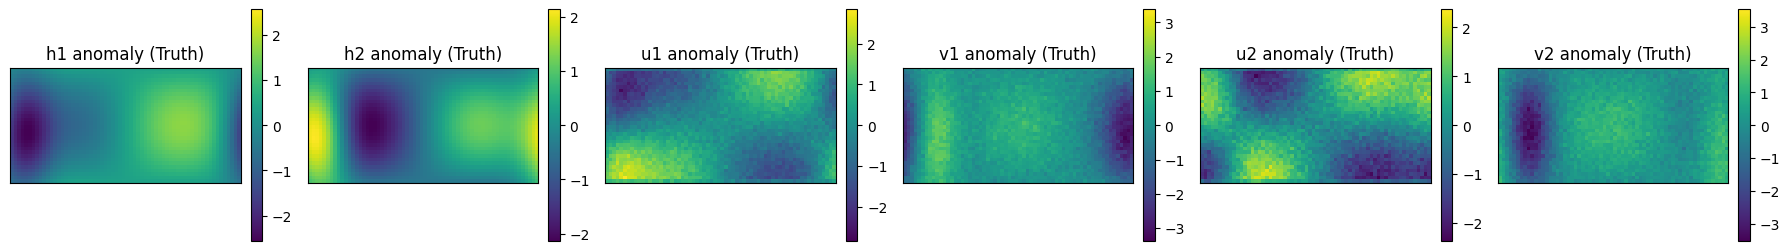

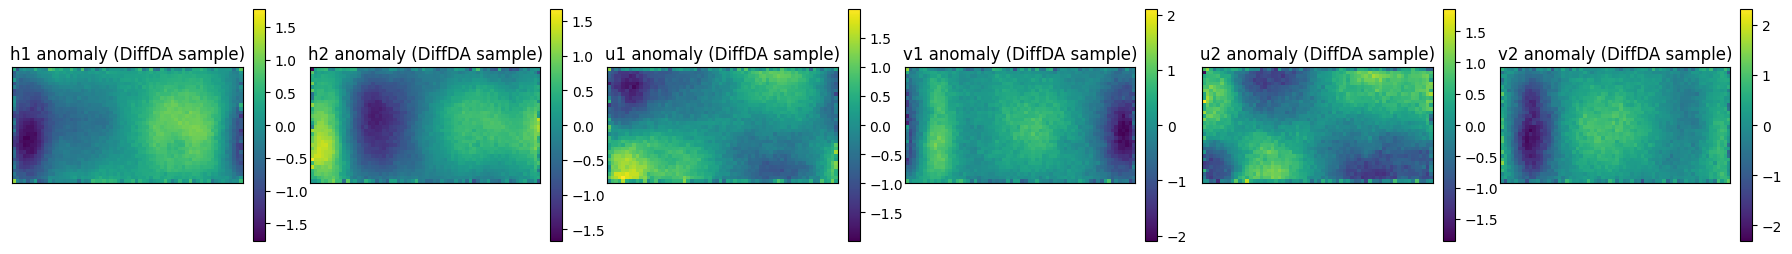


Sample RMSE (normalized units): 0.47111535


In [ ]:
# ============================================
# 7. Plot anomalies (truth vs DiffDA sample)
# ============================================
def plot_anomalies_all_vars(data, var_names, title_prefix=""):
    """
    data: (C_state,H,W)
    """
    C, H, W = data.shape
    fig, axs = plt.subplots(1, C, figsize=(3*C, 3))

    for c in range(C):
        fld = data[c]
        anom = fld - fld.mean()

        vmax = np.max(np.abs(anom))
        if vmax == 0:
            vmax = 1e-6
        vmin, vmax = -vmax, vmax

        im = axs[c].imshow(anom, origin="lower", vmin=vmin, vmax=vmax)
        axs[c].set_title(f"{var_names[c]} anomaly ({title_prefix})")
        axs[c].set_xticks([]); axs[c].set_yticks([])
        plt.colorbar(im, ax=axs[c], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


print("Truth example stats:")
for c, name in enumerate(var_names):
    fld = y_true[c]
    print(f"{name}: min={fld.min():8.3f}, max={fld.max():8.3f}, std={fld.std():8.3f}")

print("\nDiffDA sample stats:")
for c, name in enumerate(var_names):
    fld = y_pred[c]
    print(f"{name}: min={fld.min():8.3f}, max={fld.max():8.3f}, std={fld.std():8.3f}")

plot_anomalies_all_vars(y_true, var_names, title_prefix="Truth")
plot_anomalies_all_vars(y_pred, var_names, title_prefix="DiffDA sample")

sample_rmse = np.sqrt(((y_true - y_pred) ** 2).mean())
print("\nSample RMSE (normalized units):", sample_rmse)
